!pip install git+https://github.com/CC-RMD-EpiBio/autoencirt.git

In [1]:
%pylab inline
import numpy as np
import sys
sys.path.append('../bayesianquilts')

import matplotlib.pyplot as plts


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
from factor_analyzer import FactorAnalyzer

In [3]:
import tensorflow as tf
import autoencirt
from autoencirt.irt import GRModel
from autoencirt.data.rwa import item_text, get_data

dim = 2

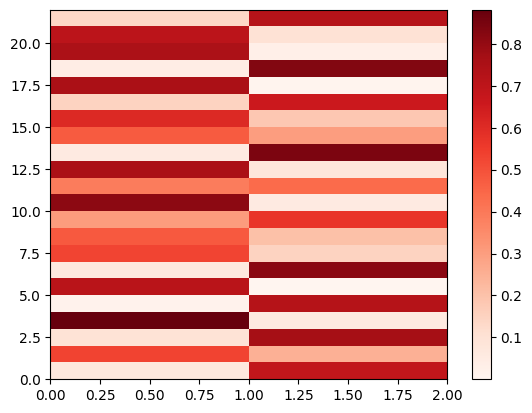

In [4]:
pd_data = get_data(reorient=True, pandas=True)
responses = pd_data[0].iloc[:, :22]
fa = FactorAnalyzer(n_factors=dim)
fa.fit(responses)
loadings = fa.loadings_
loadings.shape
plt.pcolormesh(np.abs(loadings), cmap="Reds")
plt.colorbar()

In [7]:
tfdata, num_people = get_data(reorient=True)
item_names = [f"Q{j}" for j in range(1, 23)]
grm = GRModel(
    data=tfdata,
    item_keys=item_names,
    num_people=num_people,
    dim=dim,
    eta_scale=1e-3,
    kappa_scale=1e-3,
    weight_exponent=1,
    response_cardinality=10,
    discrimination_guess=tf.cast(np.abs(loadings).T, tf.float64)[tf.newaxis, :, :, tf.newaxis]
)

batch_size = 241

def data_factory_factory(batch_size=batch_size, repeat=False, shuffle=False):
    def data_factory(batch_size=batch_size):
        if shuffle:
            out = tfdata.shuffle(batch_size*10)
        else:
            out = tfdata
        
        if repeat:
            out = out.repeat()
        return out.batch(batch_size)
    return data_factory

In [8]:
losses = grm.fit(
            data_factory_factory(shuffle=True, repeat=True),
            dataset_size=num_people,
            batches_per_step=1,
            check_every=int(num_people/batch_size),
            batch_size=batch_size,
            num_steps=3000,
            max_decay_steps=100,
            max_plateau_epochs=100,
            sample_size=32, 
            learning_rate=0.0015)

Running optimization for 3000 steps of 1 accumulated batches, checking every 41 steps
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca-1


  1%|▏         | 40/3000 [00:08<06:22,  7.74it/s] 

Step 41: average-batch loss:411696.3615870587 rel loss: 2.4289745873514032e+302
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca-2


  3%|▎         | 81/3000 [00:13<06:20,  7.66it/s]

Step 82: average-batch loss:382381.2980715877 rel loss: 0.07666448035851055
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca-3


  4%|▍         | 122/3000 [00:18<06:25,  7.47it/s]

Step 123: average-batch loss:341960.8068023393 rel loss: 0.11820211692450554
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca-4


  5%|▌         | 163/3000 [00:24<06:33,  7.21it/s]

Step 164: average-batch loss:354064.3586989932 rel loss: 0.0341846096600299
New learning rate: 0.001485


  7%|▋         | 204/3000 [00:30<06:18,  7.39it/s]

Step 205: average-batch loss:344478.6771475008 rel loss: 0.007309219734617581
New learning rate: 0.00147015


  8%|▊         | 245/3000 [00:35<06:14,  7.35it/s]

Step 246: average-batch loss:336659.08608564356 rel loss: 0.015748039889073567
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca-5


 10%|▉         | 286/3000 [00:41<06:05,  7.43it/s]

Step 287: average-batch loss:316189.9068579467 rel loss: 0.06473697858070133
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca-6


 11%|█         | 327/3000 [00:46<06:08,  7.25it/s]

Step 328: average-batch loss:341205.75953888684 rel loss: 0.0733160328675199
New learning rate: 0.0014554485


 12%|█▏        | 368/3000 [00:52<05:53,  7.44it/s]

Step 369: average-batch loss:314070.831202963 rel loss: 0.0067471265856404155
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca-7


 14%|█▎        | 409/3000 [00:57<05:54,  7.30it/s]

Step 410: average-batch loss:259901.2213836204 rel loss: 0.20842383706764878
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca-8


 15%|█▌        | 450/3000 [01:03<05:38,  7.54it/s]

Step 451: average-batch loss:231614.5797423803 rel loss: 0.12212807014438684
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca-9


 16%|█▋        | 491/3000 [01:09<05:36,  7.47it/s]

Step 492: average-batch loss:234474.34358508448 rel loss: 0.01219648938548558
New learning rate: 0.001440894015


 18%|█▊        | 532/3000 [01:14<05:34,  7.37it/s]

Step 533: average-batch loss:249508.32817949972 rel loss: 0.07171603676590069
New learning rate: 0.0014264850748499998


 19%|█▉        | 573/3000 [01:20<05:29,  7.37it/s]

Step 574: average-batch loss:277429.9917892015 rel loss: 0.16514224634239597
New learning rate: 0.0014122202241015


 20%|██        | 614/3000 [01:25<05:29,  7.24it/s]

Step 615: average-batch loss:250057.45116982042 rel loss: 0.07375453657213793
New learning rate: 0.001398098021860485


 22%|██▏       | 655/3000 [01:31<05:17,  7.38it/s]

Step 656: average-batch loss:204256.8094501217 rel loss: 0.13393810647443405
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca-10


 23%|██▎       | 696/3000 [01:36<05:12,  7.38it/s]

Step 697: average-batch loss:205784.164423602 rel loss: 0.007422121025485007
New learning rate: 0.00138411704164188


 25%|██▍       | 737/3000 [01:42<05:06,  7.39it/s]

Step 738: average-batch loss:178951.5347333352 rel loss: 0.14140853697899375
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca-11


 26%|██▌       | 778/3000 [01:48<05:02,  7.35it/s]

Step 779: average-batch loss:208636.4599261115 rel loss: 0.14228062153321241
New learning rate: 0.0013702758712254614


 27%|██▋       | 819/3000 [01:53<04:56,  7.35it/s]

Step 820: average-batch loss:188746.8057688364 rel loss: 0.05189635393087265
New learning rate: 0.0013565731125132067


 29%|██▊       | 860/3000 [01:59<06:24,  5.56it/s]

Step 861: average-batch loss:205827.161886785 rel loss: 0.13057376347749824
New learning rate: 0.0013430073813880746


 30%|███       | 901/3000 [02:06<05:27,  6.41it/s]

Step 902: average-batch loss:174716.32876920956 rel loss: 0.024240470217984623
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca-12


 31%|███▏      | 942/3000 [02:12<04:55,  6.96it/s]

Step 943: average-batch loss:182736.46573818868 rel loss: 0.043889088784664236
New learning rate: 0.001329577307574194


 33%|███▎      | 983/3000 [02:18<04:37,  7.27it/s]

Step 984: average-batch loss:146094.69209632656 rel loss: 0.1959115438226292
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca-13


 34%|███▍      | 1024/3000 [02:24<04:39,  7.08it/s]

Step 1025: average-batch loss:190868.66972261755 rel loss: 0.2345800266296159
New learning rate: 0.0013162815344984519


 36%|███▌      | 1065/3000 [02:29<04:30,  7.16it/s]

Step 1066: average-batch loss:162350.20734391274 rel loss: 0.10012623644607668
New learning rate: 0.0013031187191534673


 37%|███▋      | 1106/3000 [02:35<04:21,  7.25it/s]

Step 1107: average-batch loss:132006.45329200174 rel loss: 0.10672386427322055
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca-14


 38%|███▊      | 1147/3000 [02:41<04:18,  7.16it/s]

Step 1148: average-batch loss:146013.09886378993 rel loss: 0.09592732214288842
New learning rate: 0.0012900875319619327


 40%|███▉      | 1188/3000 [02:47<04:06,  7.36it/s]

Step 1189: average-batch loss:111090.54433846084 rel loss: 0.1882780310250003
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca-15


 41%|████      | 1229/3000 [02:53<04:09,  7.10it/s]

Step 1230: average-batch loss:122864.44932195259 rel loss: 0.09582841129771842
New learning rate: 0.0012771866566423133


 42%|████▏     | 1270/3000 [02:58<03:56,  7.31it/s]

Step 1271: average-batch loss:133667.5292271258 rel loss: 0.16890403390566533
New learning rate: 0.00126441479007589


 44%|████▎     | 1311/3000 [03:04<03:53,  7.24it/s]

Step 1312: average-batch loss:110264.11104282446 rel loss: 0.007495034311893276
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca-16


 45%|████▌     | 1352/3000 [03:10<04:01,  6.82it/s]

Step 1353: average-batch loss:106596.53041163116 rel loss: 0.034406191430721406
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca-17


 46%|████▋     | 1393/3000 [03:16<03:43,  7.18it/s]

Step 1394: average-batch loss:81215.33208027578 rel loss: 0.3125173250078915
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca-18


 48%|████▊     | 1434/3000 [03:22<03:36,  7.24it/s]

Step 1435: average-batch loss:107863.46366799451 rel loss: 0.24705429143034113
New learning rate: 0.0012517706421751314


 49%|████▉     | 1475/3000 [03:27<03:28,  7.33it/s]

Step 1476: average-batch loss:88618.19088748228 rel loss: 0.0835365598537872
New learning rate: 0.00123925293575338


 51%|█████     | 1516/3000 [03:33<03:28,  7.13it/s]

Step 1517: average-batch loss:95532.34662747069 rel loss: 0.14986562198690925
New learning rate: 0.0012268604063958462


 52%|█████▏    | 1557/3000 [03:39<03:21,  7.15it/s]

Step 1558: average-batch loss:101893.08018544121 rel loss: 0.2029357446799408
New learning rate: 0.0012145918023318877


 53%|█████▎    | 1598/3000 [03:45<03:13,  7.23it/s]

Step 1599: average-batch loss:97630.14979942256 rel loss: 0.1681326695992007
New learning rate: 0.0012024458843085688
We are in a loss plateau
Restoring from a checkpoint


 55%|█████▍    | 1639/3000 [03:50<03:18,  6.86it/s]

Step 1640: average-batch loss:66468.33572889736 rel loss: 0.22186498563055046
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca-19


 56%|█████▌    | 1680/3000 [03:56<03:02,  7.24it/s]

Step 1681: average-batch loss:56195.377338213206 rel loss: 0.1828078905646654
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca-20


 57%|█████▋    | 1721/3000 [04:02<02:59,  7.12it/s]

Step 1722: average-batch loss:77245.50873258036 rel loss: 0.27250945381486885
New learning rate: 0.001190421425465483


 59%|█████▊    | 1762/3000 [04:08<02:50,  7.25it/s]

Step 1763: average-batch loss:81566.71901321194 rel loss: 0.3110501682786721
New learning rate: 0.0011785172112108281


 60%|██████    | 1803/3000 [04:14<02:47,  7.17it/s]

Step 1804: average-batch loss:48490.86497541399 rel loss: 0.15888585131870886
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca-21


 61%|██████▏   | 1844/3000 [04:19<02:37,  7.32it/s]

Step 1845: average-batch loss:53489.45305565595 rel loss: 0.09344997555015022
New learning rate: 0.00116673203909872


 63%|██████▎   | 1885/3000 [04:25<02:32,  7.30it/s]

Step 1886: average-batch loss:40748.09427819792 rel loss: 0.19001552917675485
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca-22


 64%|██████▍   | 1926/3000 [04:31<02:17,  7.83it/s]

Step 1927: average-batch loss:48778.04149996663 rel loss: 0.16462217372491691
New learning rate: 0.0011550647187077326


 66%|██████▌   | 1967/3000 [04:36<02:22,  7.23it/s]

Step 1968: average-batch loss:44436.183368186204 rel loss: 0.08299743160725073
New learning rate: 0.0011435140715206553


 67%|██████▋   | 2008/3000 [04:42<02:16,  7.28it/s]

Step 2009: average-batch loss:55285.17436528199 rel loss: 0.2629471690011179
New learning rate: 0.001132078930805449


 68%|██████▊   | 2049/3000 [04:48<02:10,  7.26it/s]

Step 2050: average-batch loss:51634.894798403504 rel loss: 0.21084192313571237
New learning rate: 0.0011207581414973942


 70%|██████▉   | 2090/3000 [04:54<02:05,  7.24it/s]

Step 2091: average-batch loss:40913.096570098394 rel loss: 0.004032994462244392
New learning rate: 0.0011095505600824203
We are in a loss plateau
Restoring from a checkpoint


 71%|███████   | 2131/3000 [04:59<02:00,  7.19it/s]

Step 2132: average-batch loss:45408.923476328266 rel loss: 0.10264126170178962
New learning rate: 0.0010984550544815962
We are in a loss plateau
Restoring from a checkpoint


 72%|███████▏  | 2172/3000 [05:05<01:56,  7.09it/s]

Step 2173: average-batch loss:30783.56868477313 rel loss: 0.32369624508004713
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca-23


 74%|███████▍  | 2213/3000 [05:11<01:51,  7.08it/s]

Step 2214: average-batch loss:52076.58218242764 rel loss: 0.4088788588902341
New learning rate: 0.00108747050393678


 75%|███████▌  | 2254/3000 [05:17<01:44,  7.13it/s]

Step 2255: average-batch loss:48858.145234652286 rel loss: 0.36993988337199285
New learning rate: 0.0010765957988974125


 76%|███████▋  | 2295/3000 [05:22<01:37,  7.24it/s]

Step 2296: average-batch loss:35032.57636794924 rel loss: 0.12128733092732108
New learning rate: 0.001065829840908438


 78%|███████▊  | 2336/3000 [05:28<01:38,  6.76it/s]

Step 2337: average-batch loss:36493.162547522355 rel loss: 0.1564565377230335
New learning rate: 0.0010551715424993537


 79%|███████▉  | 2377/3000 [05:34<01:25,  7.29it/s]

Step 2378: average-batch loss:46721.243829024614 rel loss: 0.34112266365542543
New learning rate: 0.0010446198270743603
We are in a loss plateau
Restoring from a checkpoint


 81%|████████  | 2418/3000 [05:40<01:20,  7.27it/s]

Step 2419: average-batch loss:31546.604540395077 rel loss: 0.024187574756100554
New learning rate: 0.0010341736288036166
We are in a loss plateau
Restoring from a checkpoint


 82%|████████▏ | 2459/3000 [05:45<01:14,  7.23it/s]

Step 2460: average-batch loss:32359.79722586022 rel loss: 0.04870946903917718
New learning rate: 0.0010238318925155805
We are in a loss plateau
Restoring from a checkpoint


 83%|████████▎ | 2500/3000 [05:51<01:12,  6.90it/s]

Step 2501: average-batch loss:19420.46564885947 rel loss: 0.585109710620198
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca-24


 85%|████████▍ | 2541/3000 [05:57<01:04,  7.17it/s]

Step 2542: average-batch loss:35808.33163094716 rel loss: 0.4576551108548315
New learning rate: 0.0010135935735904246


 86%|████████▌ | 2582/3000 [06:02<00:57,  7.26it/s]

Step 2583: average-batch loss:36545.67987841206 rel loss: 0.4685975000746571
New learning rate: 0.0010034576378545204


 87%|████████▋ | 2623/3000 [06:08<00:51,  7.37it/s]

Step 2624: average-batch loss:26967.24264416872 rel loss: 0.2798497827489653
New learning rate: 0.0009934230614759751


 89%|████████▉ | 2664/3000 [06:14<00:45,  7.37it/s]

Step 2665: average-batch loss:28803.843578384483 rel loss: 0.32576825741987653
New learning rate: 0.0009834888308612154


 90%|█████████ | 2705/3000 [06:20<00:40,  7.33it/s]

Step 2706: average-batch loss:21915.373910065122 rel loss: 0.11384283341201903
New learning rate: 0.0009736539425526032
We are in a loss plateau
Restoring from a checkpoint


 92%|█████████▏| 2746/3000 [06:25<00:36,  6.91it/s]

Step 2747: average-batch loss:15406.775944804704 rel loss: 0.26051457608223455
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca-25


 93%|█████████▎| 2787/3000 [06:31<00:29,  7.34it/s]

Step 2788: average-batch loss:26194.664335032074 rel loss: 0.4118353360917064
New learning rate: 0.0009639174031270772


 94%|█████████▍| 2828/3000 [06:37<00:23,  7.37it/s]

Step 2829: average-batch loss:15338.778341779587 rel loss: 0.004433052066467726
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca/eb00e17c-7169-4f0a-b8f1-5d544bcef4ca-26


 96%|█████████▌| 2869/3000 [06:42<00:17,  7.32it/s]

Step 2870: average-batch loss:28471.78276641781 rel loss: 0.46126386016573834
New learning rate: 0.0009542782290958064


 97%|█████████▋| 2910/3000 [06:48<00:12,  7.27it/s]

Step 2911: average-batch loss:30829.31859994035 rel loss: 0.5024613245325096
New learning rate: 0.0009447354468048484


 98%|█████████▊| 2951/3000 [06:54<00:06,  7.38it/s]

Step 2952: average-batch loss:35147.08221381374 rel loss: 0.5635831660657441
New learning rate: 0.0009352880923367999


100%|█████████▉| 2992/3000 [06:59<00:01,  7.07it/s]

Step 2993: average-batch loss:20814.11507631752 rel loss: 0.2630588288025667
New learning rate: 0.0009259352114134319


100%|██████████| 3000/3000 [07:01<00:00,  5.60it/s]

Terminating because we are out of iterations


100%|██████████| 3000/3000 [07:01<00:00,  7.12it/s]


In [9]:
losses = grm.fit(
            data_factory_factory(shuffle=False, repeat=True),
            dataset_size=num_people,
            batches_per_step=1,
            check_every=int(num_people/batch_size),
            batch_size=batch_size,
            num_steps=3000,
            max_decay_steps=100,
            max_plateau_epochs=100,
            sample_size=32, 
            learning_rate=0.0005)

Running optimization for 3000 steps of 1 accumulated batches, checking every 41 steps
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/cb207367-4cad-4f7a-a763-151af7dbcdae/cb207367-4cad-4f7a-a763-151af7dbcdae-1


  1%|▏         | 40/3000 [00:07<07:05,  6.96it/s] 

Step 41: average-batch loss:15783.510817227781 rel loss: 6.335726009123996e+303
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/cb207367-4cad-4f7a-a763-151af7dbcdae/cb207367-4cad-4f7a-a763-151af7dbcdae-2


  3%|▎         | 81/3000 [00:13<07:06,  6.84it/s]

Step 82: average-batch loss:21811.071539349534 rel loss: 0.2763532599142312
New learning rate: 0.000495


  4%|▍         | 122/3000 [00:19<07:20,  6.53it/s]

Step 123: average-batch loss:23198.43622608175 rel loss: 0.3196303982126799
New learning rate: 0.00049005


  5%|▌         | 163/3000 [00:25<07:02,  6.72it/s]

Step 164: average-batch loss:17957.762287414887 rel loss: 0.12107585763683147
New learning rate: 0.00048514950000000005


  7%|▋         | 204/3000 [00:30<06:55,  6.73it/s]

Step 205: average-batch loss:12811.270518345627 rel loss: 0.23200199344990272
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/cb207367-4cad-4f7a-a763-151af7dbcdae/cb207367-4cad-4f7a-a763-151af7dbcdae-3


  8%|▊         | 245/3000 [00:36<06:41,  6.87it/s]

Step 246: average-batch loss:17776.072310371244 rel loss: 0.2792968944623926
New learning rate: 0.00048029800499999997


 10%|▉         | 286/3000 [00:42<06:32,  6.91it/s]

Step 287: average-batch loss:13673.645278695147 rel loss: 0.06306838760057511
New learning rate: 0.00047549502494999995


 11%|█         | 327/3000 [00:48<06:20,  7.02it/s]

Step 328: average-batch loss:19233.488345901766 rel loss: 0.33390811443336393
New learning rate: 0.0004707400747005


 12%|█▏        | 368/3000 [00:54<06:25,  6.82it/s]

Step 369: average-batch loss:12425.453932622593 rel loss: 0.031050502284676002
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/cb207367-4cad-4f7a-a763-151af7dbcdae/cb207367-4cad-4f7a-a763-151af7dbcdae-4


 14%|█▎        | 409/3000 [00:59<06:50,  6.31it/s]

Step 410: average-batch loss:16041.101650758603 rel loss: 0.22539896553582536
New learning rate: 0.00046603267395349497


 15%|█▌        | 450/3000 [01:06<07:07,  5.96it/s]

Step 451: average-batch loss:23740.28084002946 rel loss: 0.4766088060899631
New learning rate: 0.00046137234721396004


 16%|█▋        | 491/3000 [01:12<06:57,  6.01it/s]

Step 492: average-batch loss:20540.256907156207 rel loss: 0.39506823167856403
New learning rate: 0.00045675862374182043


 18%|█▊        | 532/3000 [01:18<05:46,  7.12it/s]

Step 533: average-batch loss:20937.726373669062 rel loss: 0.40655190010274284
New learning rate: 0.0004521910375044022


 19%|█▉        | 573/3000 [01:24<05:41,  7.10it/s]

Step 574: average-batch loss:22841.532888118432 rel loss: 0.45601488334935747
New learning rate: 0.0004476691271293582
We are in a loss plateau
Restoring from a checkpoint


 20%|██        | 614/3000 [01:29<05:39,  7.04it/s]

Step 615: average-batch loss:14191.486646178779 rel loss: 0.12444310857535917
New learning rate: 0.0004431924358580646
We are in a loss plateau
Restoring from a checkpoint


 22%|██▏       | 655/3000 [01:35<05:31,  7.06it/s]

Step 656: average-batch loss:20169.51249227908 rel loss: 0.3839487227378908
New learning rate: 0.00043876051149948394
We are in a loss plateau
Restoring from a checkpoint


 23%|██▎       | 696/3000 [01:41<05:32,  6.94it/s]

Step 697: average-batch loss:27077.156038213845 rel loss: 0.5411093426840464
New learning rate: 0.00043437290638448915
We are in a loss plateau
Restoring from a checkpoint


 25%|██▍       | 737/3000 [01:47<05:31,  6.82it/s]

Step 738: average-batch loss:15843.146720733654 rel loss: 0.21572057927345864
New learning rate: 0.00043002917732064424
We are in a loss plateau
Restoring from a checkpoint


 26%|██▌       | 778/3000 [01:53<05:18,  6.98it/s]

Step 779: average-batch loss:15515.3221620869 rel loss: 0.1991494728362574
New learning rate: 0.0004257288855474378
We are in a loss plateau
Restoring from a checkpoint


 27%|██▋       | 819/3000 [01:58<05:10,  7.02it/s]

Step 820: average-batch loss:12986.199953416573 rel loss: 0.04318014683321214
New learning rate: 0.0004214715966919634
We are in a loss plateau
Restoring from a checkpoint


 29%|██▊       | 860/3000 [02:04<05:06,  6.99it/s]

Step 861: average-batch loss:28054.9577566253 rel loss: 0.5571030959870803
New learning rate: 0.00041725688072504375
We are in a loss plateau
Restoring from a checkpoint


 30%|███       | 901/3000 [02:10<05:05,  6.87it/s]

Step 902: average-batch loss:18599.066910508565 rel loss: 0.33193132793117974
New learning rate: 0.00041308431191779333
We are in a loss plateau
Restoring from a checkpoint


 31%|███▏      | 942/3000 [02:15<04:57,  6.93it/s]

Step 943: average-batch loss:15065.264617433946 rel loss: 0.17522497957032165
New learning rate: 0.00040895346879861536
We are in a loss plateau
Restoring from a checkpoint


 33%|███▎      | 983/3000 [02:21<06:15,  5.38it/s]

Step 984: average-batch loss:21240.102837902545 rel loss: 0.4150002931977516
New learning rate: 0.0004048639341106292
We are in a loss plateau
Restoring from a checkpoint


 34%|███▍      | 1024/3000 [02:27<04:39,  7.07it/s]

Step 1025: average-batch loss:17937.422724533542 rel loss: 0.30728878259484105
New learning rate: 0.0004008152947695229
We are in a loss plateau
Restoring from a checkpoint


 36%|███▌      | 1065/3000 [02:33<04:30,  7.15it/s]

Step 1066: average-batch loss:18459.036498653135 rel loss: 0.3268633531588056
New learning rate: 0.0003968071418218277
We are in a loss plateau
Restoring from a checkpoint


 37%|███▋      | 1106/3000 [02:39<04:33,  6.91it/s]

Step 1107: average-batch loss:23797.896011834742 rel loss: 0.4778759464095738
New learning rate: 0.0003928390704036094
We are in a loss plateau
Restoring from a checkpoint


 38%|███▊      | 1147/3000 [02:44<04:22,  7.06it/s]

Step 1148: average-batch loss:15626.061379884359 rel loss: 0.20482496321062396
New learning rate: 0.00038891067969957333
We are in a loss plateau
Restoring from a checkpoint


 40%|███▉      | 1188/3000 [02:50<04:28,  6.74it/s]

Step 1189: average-batch loss:14470.3515415883 rel loss: 0.14131637390346727
New learning rate: 0.0003850215729025776
We are in a loss plateau
Restoring from a checkpoint


 41%|████      | 1229/3000 [02:56<04:15,  6.93it/s]

Step 1230: average-batch loss:15218.523354670699 rel loss: 0.18353090881126044
New learning rate: 0.0003811713571735518
We are in a loss plateau
Restoring from a checkpoint


 42%|████▏     | 1270/3000 [03:01<04:07,  7.00it/s]

Step 1271: average-batch loss:19968.67899725311 rel loss: 0.3777528331076965
New learning rate: 0.0003773596436018163
We are in a loss plateau
Restoring from a checkpoint


 44%|████▎     | 1311/3000 [03:07<04:01,  6.99it/s]

Step 1312: average-batch loss:14141.363068957697 rel loss: 0.12133972715132166
New learning rate: 0.0003735860471657981
We are in a loss plateau
Restoring from a checkpoint


 45%|████▌     | 1352/3000 [03:13<04:16,  6.42it/s]

Step 1353: average-batch loss:12191.640935127174 rel loss: 0.01917814006658818
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/cb207367-4cad-4f7a-a763-151af7dbcdae/cb207367-4cad-4f7a-a763-151af7dbcdae-5


 46%|████▋     | 1393/3000 [03:19<03:44,  7.15it/s]

Step 1394: average-batch loss:12715.666048387571 rel loss: 0.041210984250946645
New learning rate: 0.0003698501866941401


 48%|████▊     | 1434/3000 [03:24<03:47,  6.88it/s]

Step 1435: average-batch loss:13850.878225996636 rel loss: 0.11979293036850533
New learning rate: 0.00036615168482719875


 49%|████▉     | 1475/3000 [03:30<03:34,  7.10it/s]

Step 1476: average-batch loss:14484.37832836196 rel loss: 0.15829035539242722
New learning rate: 0.0003624901679789267


 51%|█████     | 1516/3000 [03:36<03:28,  7.10it/s]

Step 1517: average-batch loss:12442.994361999736 rel loss: 0.020200397071639127
New learning rate: 0.00035886526629913746


 52%|█████▏    | 1557/3000 [03:41<03:29,  6.90it/s]

Step 1558: average-batch loss:16687.518670601363 rel loss: 0.2694155928283478
New learning rate: 0.00035527661363614604
We are in a loss plateau
Restoring from a checkpoint


 53%|█████▎    | 1598/3000 [03:47<03:21,  6.95it/s]

Step 1599: average-batch loss:15199.977239562191 rel loss: 0.19791715849448646
New learning rate: 0.00035172384749978456
We are in a loss plateau
Restoring from a checkpoint


 55%|█████▍    | 1639/3000 [03:53<03:19,  6.81it/s]

Step 1640: average-batch loss:13319.392202863248 rel loss: 0.08466987461287032
New learning rate: 0.00034820660902478676
We are in a loss plateau
Restoring from a checkpoint


 56%|█████▌    | 1680/3000 [03:59<03:08,  6.99it/s]

Step 1681: average-batch loss:9762.296958794785 rel loss: 0.24884962899472246
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/cb207367-4cad-4f7a-a763-151af7dbcdae/cb207367-4cad-4f7a-a763-151af7dbcdae-6


 57%|█████▋    | 1721/3000 [04:04<03:11,  6.69it/s]

Step 1722: average-batch loss:9542.237870207799 rel loss: 0.023061580687905644
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/cb207367-4cad-4f7a-a763-151af7dbcdae/cb207367-4cad-4f7a-a763-151af7dbcdae-7


 59%|█████▊    | 1762/3000 [04:10<02:51,  7.23it/s]

Step 1763: average-batch loss:13361.26406851528 rel loss: 0.28582821046900064
New learning rate: 0.0003447245429345389


 60%|██████    | 1803/3000 [04:16<02:58,  6.71it/s]

Step 1804: average-batch loss:13900.303471264204 rel loss: 0.3135230543754487
New learning rate: 0.00034127729750519346


 61%|██████▏   | 1844/3000 [04:22<02:50,  6.77it/s]

Step 1845: average-batch loss:15964.944351028907 rel loss: 0.40230058681082587
New learning rate: 0.00033786452453014155


 63%|██████▎   | 1885/3000 [04:27<02:38,  7.02it/s]

Step 1886: average-batch loss:14170.180111812959 rel loss: 0.32659727717554415
New learning rate: 0.0003344858792848401


 64%|██████▍   | 1926/3000 [04:33<02:30,  7.12it/s]

Step 1927: average-batch loss:10491.767925311573 rel loss: 0.09050238833562231
New learning rate: 0.00033114102049199175
We are in a loss plateau
Restoring from a checkpoint


 66%|██████▌   | 1967/3000 [04:39<02:25,  7.10it/s]

Step 1968: average-batch loss:13274.959403227971 rel loss: 0.28118515617550704
New learning rate: 0.0003278296102870718
We are in a loss plateau
Restoring from a checkpoint


 67%|██████▋   | 2008/3000 [04:44<02:22,  6.97it/s]

Step 2009: average-batch loss:12549.83555626656 rel loss: 0.23965235819818895
New learning rate: 0.0003245513141842011
We are in a loss plateau
Restoring from a checkpoint


 68%|██████▊   | 2049/3000 [04:50<02:15,  7.02it/s]

Step 2050: average-batch loss:12596.783682259016 rel loss: 0.24248616862042022
New learning rate: 0.00032130580104235905
We are in a loss plateau
Restoring from a checkpoint


 70%|██████▉   | 2090/3000 [04:56<02:07,  7.16it/s]

Step 2091: average-batch loss:16869.163972855757 rel loss: 0.4343384245027048
New learning rate: 0.0003180927430319355
We are in a loss plateau
Restoring from a checkpoint


 71%|███████   | 2131/3000 [05:02<02:01,  7.14it/s]

Step 2132: average-batch loss:10658.201835841393 rel loss: 0.10470471312344941
New learning rate: 0.00031491181560161616
We are in a loss plateau
Restoring from a checkpoint


 72%|███████▏  | 2172/3000 [05:07<02:00,  6.86it/s]

Step 2173: average-batch loss:14276.343268830706 rel loss: 0.33160490116252656
New learning rate: 0.00031176269744559996
We are in a loss plateau
Restoring from a checkpoint


 74%|███████▍  | 2213/3000 [05:13<01:56,  6.75it/s]

Step 2214: average-batch loss:13361.411179370767 rel loss: 0.28583607359225255
New learning rate: 0.00030864507047114397
We are in a loss plateau
Restoring from a checkpoint


 75%|███████▌  | 2254/3000 [05:19<01:48,  6.86it/s]

Step 2255: average-batch loss:13048.276591045407 rel loss: 0.26869745566580683
New learning rate: 0.0003055586197664325
We are in a loss plateau
Restoring from a checkpoint


 76%|███████▋  | 2295/3000 [05:24<01:41,  6.94it/s]

Step 2296: average-batch loss:12546.949469707939 rel loss: 0.23947746077677337
New learning rate: 0.0003025030335687682
We are in a loss plateau
Restoring from a checkpoint


 78%|███████▊  | 2336/3000 [05:30<01:47,  6.20it/s]

Step 2337: average-batch loss:13153.51791427825 rel loss: 0.2745486087908375
New learning rate: 0.0002994780032330805
We are in a loss plateau
Restoring from a checkpoint


 79%|███████▉  | 2377/3000 [05:37<01:52,  5.52it/s]

Step 2378: average-batch loss:14533.793616687857 rel loss: 0.34344479343292045
New learning rate: 0.0002964832232007497
We are in a loss plateau
Restoring from a checkpoint


 81%|████████  | 2418/3000 [05:44<02:00,  4.84it/s]

Step 2419: average-batch loss:21543.939068619828 rel loss: 0.5570801681245608
New learning rate: 0.00029351839096874223
We are in a loss plateau
Restoring from a checkpoint


 82%|████████▏ | 2459/3000 [05:51<01:26,  6.28it/s]

Step 2460: average-batch loss:16152.547700251693 rel loss: 0.4092425512503449
New learning rate: 0.00029058320705905476
We are in a loss plateau
Restoring from a checkpoint


 83%|████████▎ | 2500/3000 [05:57<01:15,  6.62it/s]

Step 2501: average-batch loss:11417.097234514416 rel loss: 0.16421506498506738
New learning rate: 0.00028767737498846423
We are in a loss plateau
Restoring from a checkpoint


 85%|████████▍ | 2541/3000 [06:03<01:08,  6.73it/s]

Step 2542: average-batch loss:15600.619404963894 rel loss: 0.38834237138228017
New learning rate: 0.0002848006012385796
We are in a loss plateau
Restoring from a checkpoint


 86%|████████▌ | 2582/3000 [06:09<01:00,  6.94it/s]

Step 2583: average-batch loss:16005.217178758687 rel loss: 0.4038045367561914
New learning rate: 0.0002819525952261938
We are in a loss plateau
Restoring from a checkpoint


 87%|████████▋ | 2623/3000 [06:15<00:57,  6.54it/s]

Step 2624: average-batch loss:10193.913815432978 rel loss: 0.06392794338113596
New learning rate: 0.00027913306927393185
We are in a loss plateau
Restoring from a checkpoint


 89%|████████▉ | 2664/3000 [06:22<00:49,  6.73it/s]

Step 2665: average-batch loss:9647.294426986295 rel loss: 0.01088974298168223
New learning rate: 0.00027634173858119256
We are in a loss plateau
Restoring from a checkpoint


 90%|█████████ | 2705/3000 [06:28<00:42,  6.87it/s]

Step 2706: average-batch loss:13473.587998383511 rel loss: 0.2917819758662188
New learning rate: 0.00027357832119538064
We are in a loss plateau
Restoring from a checkpoint


 92%|█████████▏| 2746/3000 [06:33<00:36,  6.98it/s]

Step 2747: average-batch loss:11394.125561501376 rel loss: 0.1625300407036728
New learning rate: 0.0002708425379834268
We are in a loss plateau
Restoring from a checkpoint


 93%|█████████▎| 2787/3000 [06:39<00:30,  6.95it/s]

Step 2788: average-batch loss:23932.022880481636 rel loss: 0.6012774215592861
New learning rate: 0.00026813411260359247
We are in a loss plateau
Restoring from a checkpoint


 94%|█████████▍| 2828/3000 [06:45<00:24,  6.92it/s]

Step 2829: average-batch loss:8491.193914985586 rel loss: 0.12378046782882787
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/cb207367-4cad-4f7a-a763-151af7dbcdae/cb207367-4cad-4f7a-a763-151af7dbcdae-8


 96%|█████████▌| 2869/3000 [06:51<00:19,  6.89it/s]

Step 2870: average-batch loss:11543.293253642354 rel loss: 0.26440455696589993
New learning rate: 0.0002654527714775566


 97%|█████████▋| 2910/3000 [06:57<00:12,  7.01it/s]

Step 2911: average-batch loss:10101.780471230184 rel loss: 0.1594359094252285
New learning rate: 0.000262798243762781


 98%|█████████▊| 2951/3000 [07:03<00:07,  6.81it/s]

Step 2952: average-batch loss:11189.77644958078 rel loss: 0.2411650086804277
New learning rate: 0.0002601702613251532


100%|█████████▉| 2992/3000 [07:09<00:01,  7.07it/s]

Step 2993: average-batch loss:13702.085044355063 rel loss: 0.38029913786852765
New learning rate: 0.0002575685587119017


100%|██████████| 3000/3000 [07:10<00:00,  7.13it/s]

Terminating because we are out of iterations


100%|██████████| 3000/3000 [07:10<00:00,  6.97it/s]


In [10]:
discrim = grm.sample(100)['discriminations']
discrim.shape

TensorShape([100, 1, 2, 22, 1])

In [11]:
discrim_mean = np.mean(discrim, axis=0)

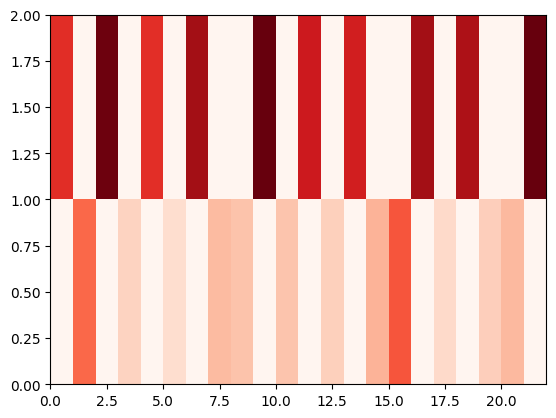

In [12]:
plt.pcolormesh(discrim_mean[0, ..., 0], vmin=0, cmap='Reds')

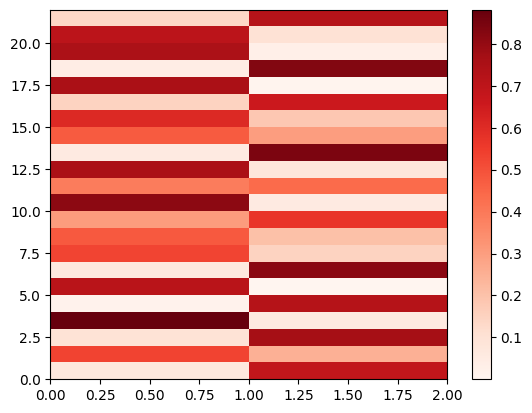

In [13]:
plt.pcolormesh(np.abs(loadings), cmap="Reds")
plt.colorbar()